In [1]:
!echo '{"username":"dorianbloy5","key":"eb5bc6e06630cc094d7d6946d4f4b9aa"}' > kaggle.json
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets download mehradaria/covid19-lung-ct-scans
#!unzip covid19-lung-ct-scans.zip
!kaggle datasets download -d azaemon/preprocessed-ct-scans-for-covid19
!unzip preprocessed-ct-scans-for-covid19.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: Preprocessed CT scans/nCT/nCT9081.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9082.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9083.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9084.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9085.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9086.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9087.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9088.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9089.jpg  
  inflating: Preprocessed CT scans/nCT/nCT909.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9090.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9091.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9092.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9093.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9094.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9095.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9096.jpg  
  inflating: Preprocessed CT scans/nCT/nCT9097.jpg  
  inflating: Preproc

In [2]:
!rm COVID-19_Lung_CT_Scans/COVID-19/desktop.ini

rm: cannot remove 'COVID-19_Lung_CT_Scans/COVID-19/desktop.ini': No such file or directory


# 1.prepair the dataset of covid

In [3]:
import torch

from torch.utils.data import Dataset, DataLoader

from torch.utils.data import Dataset

from PIL import Image


torch.cuda.empty_cache()




import os
def r_txt(txt_path):
    txt_data=[]
    for file_name in os.listdir(txt_path):
        txt_data.append(file_name)
    # with open(txt_path) as f:
    #     lines = f.readlines()
    # txt_data = [line.strip() for line in lines]
    return txt_data


class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):

        self.root_dir = root_dir
        self.txt_path = [txt_COVID, txt_NonCOVID]

        #这里换数据集
        #self.classes = ['COVID-19', 'Non-COVID-19']
        self.classes = ['pCT', 'nCT']

        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir, self.classes[c], item), c] for item in r_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform
        # print("img_list",self.img_list)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        # print("sample",sample)
        return image, int(self.img_list[idx][1])

# 2. complex CNN import

In [4]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module, Parameter, init
from torch.nn import Conv2d, Linear, BatchNorm2d
from torch.nn.functional import relu
from torchvision import datasets, transforms

## 2.1 linear function

In [5]:
class linear_function(Module):

    def __init__(self, i_f, o_f):
        super(linear_function, self).__init__()
        self.fc_r = Linear(i_f, o_f)
        self.fc_i = Linear(i_f, o_f)

    def forward(self, r, i):
        return self.fc_r(r) - self.fc_i(i), self.fc_r(i) + self.fc_i(r)

## 2.2 construct Conv2d ，it has two layers ,r and i parts

In [6]:
class CC2d(Module):

    def __init__(self, i_c, o_c, kernel_size=3, stride=1, padding=0,
                 dilation=1, g=1, bias=True):
        super(CC2d, self).__init__()
        self.c_r = Conv2d(i_c, o_c, kernel_size, stride, padding, dilation, g, bias)
        self.c_i = Conv2d(i_c, o_c, kernel_size, stride, padding, dilation, g, bias)

    def forward(self, r, i):
        assert (r.size() == i.size())
        return self.c_r(r) - self.c_i(i), self.c_r(i) + self.c_i(r)

## 2.3 batch norm

In [7]:

class batch_norm(Module):

    def __init__(self, n_f, ep=1e-5, mom=0.1, af=True,
                 stats=True):
        super(batch_norm, self).__init__()

        self.af = af
        self.stats = stats

        self.n_f = n_f
        self.ep = ep
        self.mom = mom
        if self.af:
#comment one and use one, can change from these two, two methods of weight initialization
  #--------------------------------------------------------------------------------------------
            #this is using Tensor Parameter for weight initialization
            #self.weight = Parameter(torch.Tensor(n_f, 3))
            #self.bias = Parameter(torch.Tensor(n_f, 2))
  #---------------------------------------------------------------------------------------------
            #this is using Linear for weight initialization
            self.weight = torch.nn.Linear(3, n_f).weight
            self.bias = torch.nn.Linear(2, n_f).weight
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)
        if self.stats:
            self.register_buffer('running_mean', torch.zeros(n_f, 2))
            self.register_buffer('running_covar', torch.zeros(n_f, 3))
            self.running_covar[:, 0] = 1.4142135623730951
            self.running_covar[:, 1] = 1.4142135623730951
            self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))
        else:
            self.register_parameter('running_mean', None)
            self.register_parameter('running_covar', None)
            self.register_parameter('num_batches_tracked', None)
        self.reset_parameters()

    def reset_running_stats(self):
        if self.stats:
            self.running_mean.zero_()
            self.running_covar.zero_()
            self.running_covar[:, 0] = 1.4142135623730951
            self.running_covar[:, 1] = 1.4142135623730951
            self.num_batches_tracked.zero_()

    def reset_parameters(self):
        self.reset_running_stats()
        if self.af:
            init.constant_(self.weight[:, :2], 1.4142135623730951)
            init.zeros_(self.weight[:, 2])
            init.zeros_(self.bias)

In [8]:
class batch_norm2d(batch_norm):

    def forward(self, r, i):

        expo = 0.0

        if self.training and self.stats:
            if self.num_batches_tracked is not None:
                self.num_batches_tracked += 1
                if self.mom is None:  # use cumulative moving average
                    expo = 1.0 / float(self.num_batches_tracked)
                else:  # use exponential moving average
                    expo = self.mom

        if self.training:

            # calculate mean of real and imaginary part
            real_mean = r.mean([0, 2, 3])
            i_mean = i.mean([0, 2, 3])

            mean = torch.stack((real_mean, i_mean), dim=1)

            # update running mean
            with torch.no_grad():
                self.running_mean = expo * mean \
                                    + (1 - expo) * self.running_mean

            r = r - real_mean[None, :, None, None]
            i = i - i_mean[None, :, None, None]

            # Elements of the covariance matrix (biased for train)
            n = r.numel() / r.size(1)
            RR = 1. / n * r.pow(2).sum(dim=[0, 2, 3]) + self.ep
            II = 1. / n * i.pow(2).sum(dim=[0, 2, 3]) + self.ep
            RI = (r.mul(i)).mean(dim=[0, 2, 3])

            with torch.no_grad():
                self.running_covar[:, 0] = expo * RR * n / (n - 1) \
                                           + (1 - expo) * self.running_covar[:, 0]

                self.running_covar[:, 1] = expo * II * n / (n - 1) \
                                           + (1 - expo) * self.running_covar[:, 1]

                self.running_covar[:, 2] = expo * RI * n / (n - 1) \
                                           + (1 - expo) * self.running_covar[:, 2]

        else:
            mean = self.running_mean
            RR = self.running_covar[:, 0] + self.ep
            II = self.running_covar[:, 1] + self.ep
            RI = self.running_covar[:, 2]  # +self.ep

            r = r - mean[None, :, 0, None, None]
            i = i - mean[None, :, 1, None, None]

        # calculate the inverse square root the covariance matrix
        c = RR * II - RI.pow(2)
        s = torch.sqrt(c)
        t = torch.sqrt(II + RR + 2 * s)
        inv_st = 1.0 / (s * t)
        R_rr = (II + s) * inv_st
        R_II = (RR + s) * inv_st
        R_RI = -RI * inv_st

        r, i = R_rr[None, :, None, None] * r + R_RI[None, :, None, None] * i, \
                           R_II[None, :, None, None] * i + R_RI[None, :, None, None] * r

        if self.af:
            r, i = self.weight[None, :, 0, None, None] * r + self.weight[None, :, 2, None,
                                                                               None] * i + \
                               self.bias[None, :, 0, None, None], \
                               self.weight[None, :, 2, None, None] * r + self.weight[None, :, 1, None,
                                                                               None] * i + \
                               self.bias[None, :, 1, None, None]

        return r, i

# 3 define the complex cnn model

In [9]:

class Model_complex(nn.Module):

    def __init__(self):
        super(Model_complex, self).__init__()
        self.conv1 = CC2d(1, 20, 5, 2)
        self.bn = batch_norm2d(20)
        self.conv2 = CC2d(20, 50, 5, 2)
        self.fc1 = linear_function(4 * 4 * 50, 500)
        self.fc2 = linear_function(500, 10)

        self.img = BatchNorm2d(1)
        self.conimg = Conv2d(1, 1, 3, 1, padding=1)

    def forward(self, x):
        X_R = x
        # imaginary part BN-ReLU-Conv-BN-ReLU-Conv as shown in paper
        X_I = self.img(X_R)
        X_I = relu(X_I)
        X_I = self.conimg(X_I)

        # flow into complex net
        X_R, X_I = self.conv1(X_R, X_I)
        X_R = relu(X_R)
        X_I = relu(X_I)
        X_R, X_I = self.bn(X_R, X_I)
        X_R, X_I = self.conv2(X_R, X_I)
        X_R = relu(X_R)
        X_I = relu(X_I)
        #         print(X_R.shape)
        X_R = X_R.reshape(-1, 4 * 4 * 50)
        X_I = X_I.reshape(-1, 4 * 4 * 50)
        X_R, X_I = self.fc1(X_R, X_I)
        X_R = relu(X_R)
        X_I = relu(X_I)
        X_R, X_I = self.fc2(X_R, X_I)
        x = torch.sqrt(torch.pow(X_R, 2) + torch.pow(X_I, 2))
        return F.log_softmax(x, dim=1)

# 4 train complex cnn model

13980
Model_complex(
  (conv1): CC2d(
    (c_r): Conv2d(1, 20, kernel_size=(5, 5), stride=(2, 2))
    (c_i): Conv2d(1, 20, kernel_size=(5, 5), stride=(2, 2))
  )
  (bn): batch_norm2d()
  (conv2): CC2d(
    (c_r): Conv2d(20, 50, kernel_size=(5, 5), stride=(2, 2))
    (c_i): Conv2d(20, 50, kernel_size=(5, 5), stride=(2, 2))
  )
  (fc1): linear_function(
    (fc_r): Linear(in_features=800, out_features=500, bias=True)
    (fc_i): Linear(in_features=800, out_features=500, bias=True)
  )
  (fc2): linear_function(
    (fc_r): Linear(in_features=500, out_features=10, bias=True)
    (fc_i): Linear(in_features=500, out_features=10, bias=True)
  )
  (img): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conimg): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Train Epoch:   0 [     0/ 13980 (  0%)]	Loss: 2.305773	Accuracy: 0.000143
Train Epoch:   0 [  3200/ 13980 ( 23%)]	Loss: 0.148426	Accuracy: 0.189199
Train Epoch:   0 [  6400/ 13980 ( 46%)]	

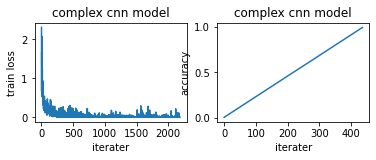

In [18]:

if __name__ == '__main__':

    trans = transforms.Compose([
        transforms.Resize(28),
        transforms.CenterCrop(28),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (1.0,))
    ])
    #"C:\Users\86130\Downloads\COVID-CT-master (1)\COVID-CT-master\covid19-lung-ct-scans\COVID-19_Lung_CT_Scans\COVID-19"
    #"C:\Users\86130\Downloads\COVID-CT-master (1)\COVID-CT-master\covid19-lung-ct-scans\COVID-19_Lung_CT_Scans"

    #这里可以换数据集

    # trainset = CovidCTDataset(root_dir='COVID-19_Lung_CT_Scans',
    #                           txt_COVID='COVID-19_Lung_CT_Scans/COVID-19',
    #                           txt_NonCOVID='COVID-19_Lung_CT_Scans/Non-COVID-19',
    #                           transform=trans)

    trainset = CovidCTDataset(root_dir='Preprocessed CT scans',
                              txt_COVID='Preprocessed CT scans/pCT',
                              txt_NonCOVID='Preprocessed CT scans/nCT',
                              transform=trans)
    # valset = CovidCTDataset(root_dir='../../Images-processed',
    #                         txt_COVID='../../Data-split/COVIDalCT_COVID.txt',
    #                         txt_NonCOVID='../../Data-split/NonCOVIDalCT_NonCOVID.txt',
    #                         transform=trans)
    # testset = CovidCTDataset(root_dir='../../Images-processed',
    #                          txt_COVID='../../Data-split/COVID/testCT_COVID.txt',
    #                          txt_NonCOVID='../../Data-split/NonCOVID/testCT_NonCOVID.txt',
    #                          transform=trans)
    print(trainset.__len__())
    # print(valset.__len__())
    # print(testset.__len__())

    batchsize = 32
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    # train_set = datasets.MNIST('../data', train=True, transform=trans, download=True)
    # test_set = datasets.MNIST('../data', train=False, transform=trans, download=True)
    # train_loader = torch.utils.data.DataLoader(train_set, batch_size=batchsize, shuffle=True)
    # test_loader = torch.utils.data.DataLoader(test_set, batch_size=batchsize, shuffle=True)

    train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
    # val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
    # test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = Model_complex().to(device)
    print(model)
    learn_rate=0.01
    momentum=0.9
    optimizer = torch.optim.SGD(model.parameters(), learn_rate, momentum)

    # train step
    train_loss = []
    accuracy_list=[]
    for epoch in range(5):
        num_correct=0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            # print("data",data)
            # print(data.shape)
            #print("target",target)
            # print(target.shape)
            # print("batch_idx",batch_idx,"tata",len(data))

            optimizer.zero_grad()
            output=model(data)
            #print("output",output)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            
            pred=output.argmax(dim=1)
            num_correct+=torch.eq(pred,target).sum().float().item()
            train_loss.append(loss.item())
            if epoch==4:
              accuracy_list.append(num_correct/len(train_loader.dataset))
            if batch_idx % 100 == 0:
                print('Train Epoch: {:3} [{:6}/{:6} ({:3.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.6f}'.format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item(),num_correct/len(train_loader.dataset))
                )
    plt.subplot(221)
    plt.title("complex cnn model")
    plt.xlabel("iterater")
    plt.ylabel("train loss")
    plt.plot(train_loss)

    plt.subplot(222)
    plt.title("complex cnn model")
    plt.xlabel("iterater")
    plt.ylabel("accuracy")
    plt.plot(accuracy_list)
    plt.show()

# define real number cnn

In [15]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# train real number cnn network

13980
[1, 100] loss: 0.907 accuracy: 0.200
[1, 200] loss: 0.623 accuracy: 0.401
[1, 300] loss: 0.596 accuracy: 0.601
[1, 400] loss: 0.611 accuracy: 0.801
[2, 100] loss: 0.593 accuracy: 0.200
[2, 200] loss: 0.577 accuracy: 0.401
[2, 300] loss: 0.589 accuracy: 0.601
[2, 400] loss: 0.573 accuracy: 0.801
[3, 100] loss: 0.433 accuracy: 0.200
[3, 200] loss: 0.417 accuracy: 0.401
[3, 300] loss: 0.335 accuracy: 0.601
[3, 400] loss: 0.303 accuracy: 0.801
[4, 100] loss: 0.274 accuracy: 0.200
[4, 200] loss: 0.222 accuracy: 0.401
[4, 300] loss: 0.200 accuracy: 0.601
[4, 400] loss: 0.191 accuracy: 0.801
[5, 100] loss: 0.178 accuracy: 0.200
[5, 200] loss: 0.162 accuracy: 0.401
[5, 300] loss: 0.149 accuracy: 0.601
[5, 400] loss: 0.133 accuracy: 0.801


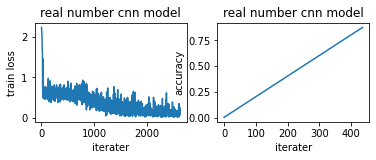

In [19]:
import torch.optim as optim
if __name__ == '__main__':

    trans = transforms.Compose([
        transforms.Resize(28),
        transforms.CenterCrop(28),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (1.0,))
    ])
    #"C:\Users\86130\Downloads\COVID-CT-master (1)\COVID-CT-master\covid19-lung-ct-scans\COVID-19_Lung_CT_Scans\COVID-19"
    #"C:\Users\86130\Downloads\COVID-CT-master (1)\COVID-CT-master\covid19-lung-ct-scans\COVID-19_Lung_CT_Scans"

    #这里可以换数据集

    # trainset = CovidCTDataset(root_dir='COVID-19_Lung_CT_Scans',
    #                           txt_COVID='COVID-19_Lung_CT_Scans/COVID-19',
    #                           txt_NonCOVID='COVID-19_Lung_CT_Scans/Non-COVID-19',
    #                           transform=trans)

    trainset = CovidCTDataset(root_dir='Preprocessed CT scans',
                              txt_COVID='Preprocessed CT scans/pCT',
                              txt_NonCOVID='Preprocessed CT scans/nCT',
                              transform=trans)
    
    
    

    # valset = CovidCTDataset(root_dir='../../Images-processed',
    #                         txt_COVID='../../Data-split/COVID/valCT_COVID.txt',
    #                         txt_NonCOVID='../../Data-split/NonCOVID/valCT_NonCOVID.txt',
    #                         transform=trans)
    # testset = CovidCTDataset(root_dir='../../Images-processed',
    #                          txt_COVID='../../Data-split/COVID/testCT_COVID.txt',
    #                          txt_NonCOVID='../../Data-split/NonCOVID/testCT_NonCOVID.txt',
    #                          transform=trans)
    print(trainset.__len__())
    # print(valset.__len__())
    # print(testset.__len__())

    batchsize = 32
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    # train_set = datasets.MNIST('../data', train=True, transform=trans, download=True)
    # test_set = datasets.MNIST('../data', train=False, transform=trans, download=True)
    # train_loader = torch.utils.data.DataLoader(train_set, batch_size=batchsize, shuffle=True)
    # test_loader = torch.utils.data.DataLoader(test_set, batch_size=batchsize, shuffle=True)

    train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
    # val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
    # test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = LeNet5().to(device)

    criterion = nn.CrossEntropyLoss()  # cross entropy loss always use for classfication
    learn_rate=0.01
    momentum=0.9
    optimizer = optim.SGD(net.parameters(), learn_rate, momentum)

    # training real number model

    train_loss = []
    accuracy_list=[]
    
    for epoch in range(5):
        sum_loss = 0.0
        # read the data
        num_correct=0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the dradient
            optimizer.zero_grad()

            # forward + backward
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            

            pred=output.argmax(dim=1)
            num_correct+=torch.eq(pred,target).sum().float().item()

            train_loss.append(loss.item())

            if epoch==4:
              train_loss.append(loss.item())
              accuracy_list.append(num_correct/len(train_loader.dataset))

            # for every 100 batch training print mean loss once
            sum_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %d] loss: %.03f accuracy: %.03f'
                      % (epoch + 1, i + 1, sum_loss / 100,num_correct/len(train_loader.dataset)))
                sum_loss = 0.0
    


    plt.subplot(221)
    plt.title("real number cnn model")
    plt.xlabel("iterater")
    plt.ylabel("train loss")
    plt.plot(train_loss)

    plt.subplot(222)
    plt.title("real number cnn model")
    plt.xlabel("iterater")
    plt.ylabel("accuracy")
    plt.plot(accuracy_list)
    plt.show()